In [6]:
import tensorflow as  tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import sys
from pathlib import Path
import shutil
import datetime
from functools import partial

In [7]:
sys.path.append('../utils')

In [8]:
from data_preparing import ChannelData, random_rotation
from model import ChannelCutter, LRFinder
from focal_tversky_loss import *
from cldice_loss import SoftClDice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## using topology preserving loss function

- SoftClDice: compares skeleton of the masks. Channels are equal weights regardless of width.

In [9]:
train_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320/train'),
    elevation='elevation'
)
val_data = ChannelData(
    path=Path('../data/crop_arkansas_512x320/val'),
    elevation='elevation'
)
train_data.add_process(random_rotation)
val_data.add_process(random_rotation)

model = ChannelCutter({
    'input_shape': [512, 320, 4],
    'n_classes': 2
})


BATCH_SIZE = 2
BUFFER_SIZE = 6

train_dataset =  train_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset =  val_data.data\
    .shuffle(BUFFER_SIZE)\
    .batch(BATCH_SIZE)\
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

loss = SoftClDice()
# IOULoss(fp_weight=0.25)
# used for model name tagging
session_labels = ['arkansas', 'crop512x320', 'no_rotation', 'softcldice']

# first run use fild_lr to find learning rate
find_lr = False

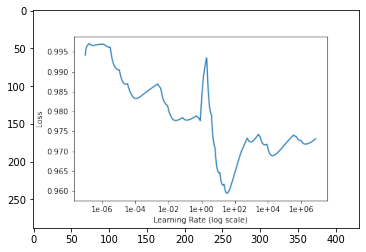

In [10]:
image_name = 'logs/lr_' + '_'.join(session_labels) + '.png'
if find_lr:
    model.compile_model(
        optimizer='adam', 
        loss=loss.loss, 
        metrics=['accuracy']
    )

    lr_finder = LRFinder(start_lr=1e-7, end_lr=10, max_steps=336)
    model.unet.fit(
        train_dataset, epochs=2, 
        callbacks=[lr_finder]
    )
    
    lr_finder.plot()
    plt.savefig(image_name)
else:
    img = mpimg.imread(image_name)
    plt.imshow(img)
    plt.show()

In [11]:
model.unet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 320, 4) 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 512, 320, 32) 6304        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 512, 320, 32) 128         input_conv[0][0]                 
__________________________________________________________________________________________________
pre_unet_conv_step0 (Conv2D)    (None, 512, 320, 32) 9248        batch_normalization_24[0][0]     
_______________________________________________________________________________________

In [12]:
initial_learning_rate = 1e-2
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=300,
    decay_rate=0.1,
    staircase=True)

model.compile_model(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    loss=reduced_iou_loss, 
    metrics=['accuracy', tp, tn]
)

session_labels.append('lr1e-2_to_lr1e-3')
session_name = '_'.join(session_labels)
save_path = Path("./logs") / session_name / ('trained_on_'+str(datetime.datetime.now()))
os.makedirs(save_path)
# callback that records training metrics for diagnosis
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=save_path)
# callback that stops training if the monitored metric doesn't improve after specified epochs of training (patience)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# train_dataset =  train_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_dataset =  val_data.data\
#     .shuffle(BUFFER_SIZE)\
#     .batch(BATCH_SIZE)\
#     .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.unet.fit(
    train_dataset, epochs=10, validation_data=val_dataset,
    callbacks=[tensorboard_callback, early_stopping_callback]
)

Epoch 1/10
  1/292 [..............................] - ETA: 0s - loss: 0.9429 - accuracy: 0.6436 - tp: 0.3809 - tn: 0.6512WARNING:tensorflow:From /home/yao/develop/channel_image_segmentation/.venv/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
292/292 [==============================] - 150s 513ms/step - loss: 0.6126 - accuracy: 0.9393 - tp: 0.5023 - tn: 0.9539 - val_loss: 0.5727 - val_accuracy: 0.9678 - val_tp: 0.4328 - val_tn: 0.9843
Epoch 2/10
292/292 [==============================] - 150s 514ms/step - loss: 0.4999 - accuracy: 0.9684 - tp: 0.5399 - tn: 0.9828 - val_loss: 0.5267 - val_accuracy: 0.9686 - val_tp: 0.4943 - val_tn: 0.9835
Epoch 3/10
292/292 [==============================] - 150s 515ms/step - loss: 0.4848 - accuracy: 0.9704 - tp: 0.5479 - tn: 0.9847 - val_loss: 0.5202 - val_accur

In [8]:
import json

In [9]:
with open(save_path / 'model_config.json', 'w') as fp:
    fp.write(str(model.unet.get_config()))

In [10]:
model_path = str(save_path).replace('logs', 'models')
os.makedirs(model_path)

In [11]:
save_path

PosixPath('logs/arkansas_crop512x320_no_rotation_fp025_lr1e-3_to_lr1e-4/trained_on_2020-10-09 09:37:16.147797')

In [12]:
class SaveFigCallback(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        self.save_path = save_path
        self.image_counter = 0
        super().__init__()
        
    def on_predict_batch_end(self, batch, logs=None):
        for img in batch:
            self.image_counter += 1
            tf.keras.preprocessing.image.save_img(
                self.save_path / ('image_' + str(self.image_counter) + '.png'),
                img
            )


In [13]:
model.unet.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/arkansas_crop512x320_no_rotation_fp025_lr1e-3_to_lr1e-4/trained_on_2020-09-25 20:20:25.648688/assets


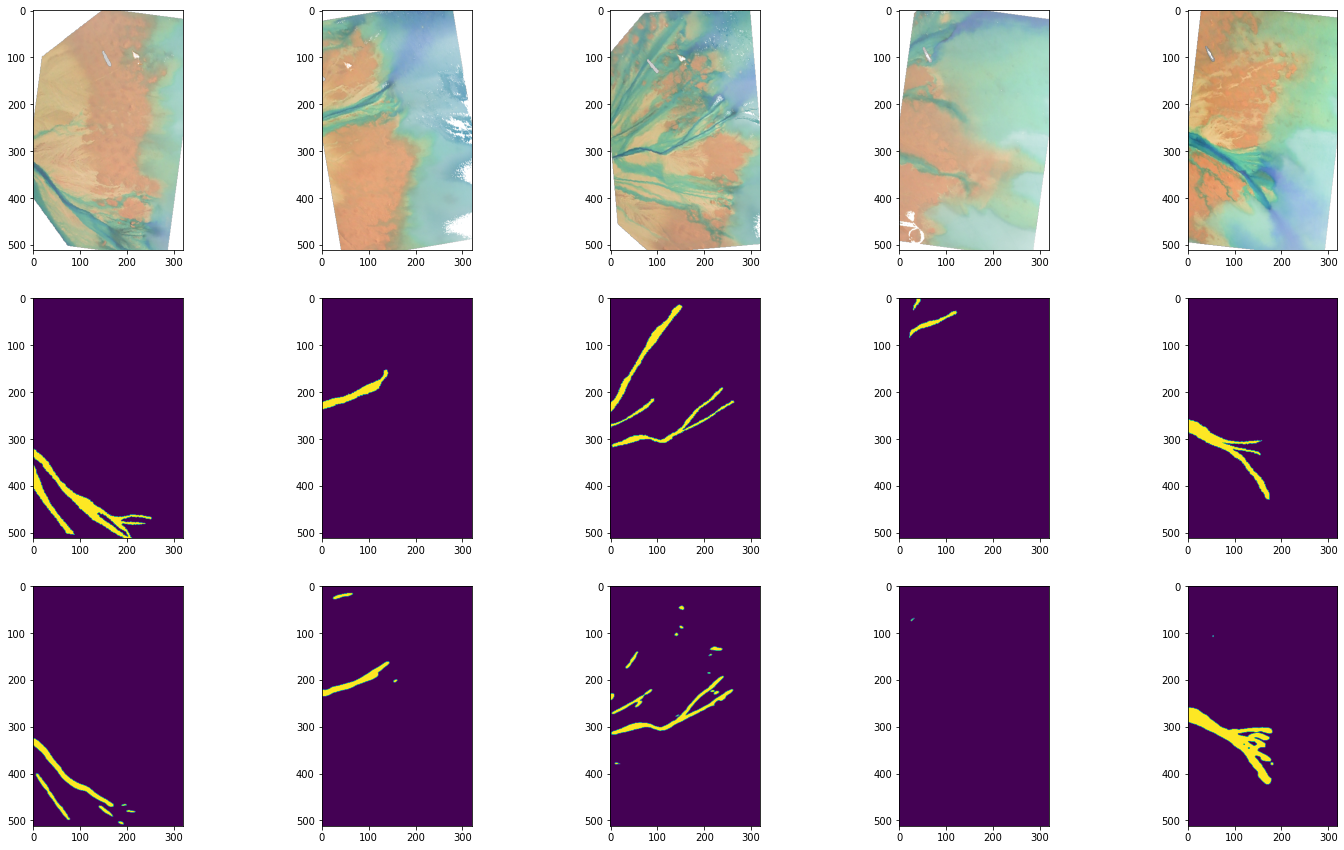

<Figure size 432x288 with 0 Axes>

In [13]:
n_samples = 5

fig, axes = plt.subplots(nrows=3, ncols=n_samples, figsize=(n_samples*5, 15))
i = 0
tf.random.set_seed(2)
for x, y in val_dataset.take(5):
    axes[0][i].imshow(x[0, :, : :])
    axes[1][i].imshow(y[0, :, : :])
    axes[2][i].imshow(model.unet.predict(x)[0, :, :, 1])
    i += 1

plt.show()
plt.savefig(save_path / 'example_vals_1.png')

## save all predictions to files

In [25]:
def save_predictions(dataset, save_path):
    i = 0
    for x, y in dataset.batch(1):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
        axes[0].imshow(x[0, :, :, :3])
        axes[1].imshow(x[0, :, :, 3])
        axes[2].imshow(y[0, :, : :])
        axes[3].imshow(model.unet.predict(x)[0, :, :, 1])
        i += 1
        plt.savefig(save_path / f'vals_{str(i)}.png')
        plt.close()

In [26]:
save_predictions(val_data.data, save_path)